# MNIST dataset with SGD/Thresholded update/Manhattan Learning

All models have stochastic input encoding added directly to the crossbar model.

##Manhattan Optimizer

In [ ]:
import torch
from torch import Tensor
from torch.optim.optimizer import Optimizer, required
from typing import List, Optional
import numpy as np

count_list = []
last_layer = []
device = 'cuda' if torch.cuda.is_available() else 'cpu'

class ManhattanSGD(Optimizer):
    def __init__(self, params, lr=required, momentum=0, dampening=0,
                 weight_decay=0, nesterov=False, *, maximize=False, foreach: Optional[bool] = None):
        if lr is not required and lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if momentum < 0.0:
            raise ValueError("Invalid momentum value: {}".format(momentum))
        if weight_decay < 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))

        defaults = dict(lr=lr, momentum=momentum, dampening=dampening,
                        weight_decay=weight_decay, nesterov=nesterov,
                        maximize=maximize, foreach=foreach)
        if nesterov and (momentum <= 0 or dampening != 0):
            raise ValueError("Nesterov momentum requires a momentum and zero dampening")
        super(ManhattanSGD, self).__init__(params, defaults)

    def __setstate__(self, state):
        super().__setstate__(state)
        for group in self.param_groups:
            group.setdefault('nesterov', False)
            group.setdefault('maximize', False)
            group.setdefault('foreach', None)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs the Manhattan Learning rule such that
        \Delta W(i,j) = sgn(\Delta w(i,j))
        Args:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            params_with_grad = []
            d_p_list = []
            momentum_buffer_list = []
            has_sparse_grad = False

            weight_decay = group['weight_decay']
            momentum = group['momentum']
            dampening = group['dampening']
            nesterov = group['nesterov']

            for p in group['params']:
                if p.grad is None:
                    continue
                d_p = p.grad.data

                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)
                if momentum != 0:
                    param_state = self.state[p]
                    if 'momentum_buffer' not in param_state:
                        # buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()
                        #buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()#.mul_(group['lr'])
                        buf = param_state['momentum_buffer'] =  torch.from_numpy(np.where(torch.clone(d_p).cpu().detach()>0, 1, -1)).to(device)
                    else:
                        buf = param_state['momentum_buffer'].float()
                        #buf.mul_(momentum).add_(1 - dampening, d_p)
                        #buf.add_(1 - dampening, torch.from_numpy(np.where(torch.clone(d_p).cpu().detach()>0, 1, -1)).to(device))
                        #buf = param_state['momentum_buffer'] = torch.clone(d_p).detach()#.mul_(group['lr'])
                        buf = param_state['momentum_buffer'] =  torch.from_numpy(np.where(torch.clone(d_p).cpu().detach()>0, 1, -1)).to(device)
                    if nesterov:
                        d_p = d_p.add(momentum, buf)
                    else:
                        d_p = buf
                    p.data.add_(-group['lr'], d_p)
                else:
                    p.data.add_(-group['lr'], d_p)


        return loss


## MNIST example in Pytorch


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

In [ ]:
class Net_ex(nn.Module):
    def __init__(self):
        super(Net_ex, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 3)
        self.conv2 = nn.Conv2d(16, 64, 3, 3)
        self.fc1 = nn.Linear(64, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
def train(model, device, train_loader, optimizer, epoch):

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()

        #print(optimizer.loss_and_gradients(model_objective))
        optimizer.step()
        if batch_idx % 128 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
def test(model, device, test_loader, prints = True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    if prints:
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
    return 100. * correct / len(test_loader.dataset)

In [ ]:
MNISTtransform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))])

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../datasets/', train=False, download=True,
                               transform=MNISTtransform),
                               batch_size=32, shuffle=True)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../datasets/', train=True, download=True,
                               transform=MNISTtransform),
                               batch_size=32, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../datasets/MNIST/raw/train-images-idx3-ubyte.gz to ../datasets/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../datasets/MNIST/raw/train-labels-idx1-ubyte.gz to ../datasets/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../datasets/MNIST/raw/t10k-images-idx3-ubyte.gz to ../datasets/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../datasets/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../datasets/MNIST/raw



In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
torch.manual_seed(88)

model = Net_ex().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

scheduler = StepLR(optimizer, step_size=1, gamma=0.9)
for epoch in range(1, 6):
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)
    scheduler.step()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.308532
Train Epoch: 1 [4096/60000 (7%)]	Loss: 0.985617
Train Epoch: 1 [8192/60000 (14%)]	Loss: 0.412349
Train Epoch: 1 [12288/60000 (20%)]	Loss: 0.458174
Train Epoch: 1 [16384/60000 (27%)]	Loss: 0.279242
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.242156
Train Epoch: 1 [24576/60000 (41%)]	Loss: 0.214007
Train Epoch: 1 [28672/60000 (48%)]	Loss: 0.453503
Train Epoch: 1 [32768/60000 (55%)]	Loss: 0.324504
Train Epoch: 1 [36864/60000 (61%)]	Loss: 0.476829
Train Epoch: 1 [40960/60000 (68%)]	Loss: 0.802377
Train Epoch: 1 [45056/60000 (75%)]	Loss: 0.330615
Train Epoch: 1 [49152/60000 (82%)]	Loss: 0.173653
Train Epoch: 1 [53248/60000 (89%)]	Loss: 0.706552
Train Epoch: 1 [57344/60000 (96%)]	Loss: 0.341181

Test set: Average loss: 0.2920, Accuracy: 9122/10000 (91%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.224121
Train Epoch: 2 [4096/60000 (7%)]	Loss: 0.407726
Train Epoch: 2 [8192/60000 (14%)]	Loss: 0.134190
Train Epoch: 2 [12288/60000 (20%)]	Loss: 0.218614
Train

In [ ]:
print(test(model, device, test_loader))


Test set: Average loss: 0.1844, Accuracy: 9451/10000 (95%)

94.51


In [ ]:
print(model.fc1.weight.data.shape)

torch.Size([10, 64])


In [ ]:
import copy
org_weight = copy.deepcopy(model.fc1.weight.data)
org_acc = test(model, device, test_loader)

results = []

for i in range(model.fc1.weight.data.shape[0]):
    res = []
    for j in range(model.fc1.weight.data.shape[1]):
        model.fc1.weight.data = copy.deepcopy(org_weight)
        model.fc1.weight.data[i][j] = model.fc1.weight.data[i][j] + 1

        acc_1 = test(model, device, test_loader, prints = False)

        model.fc1.weight.data = copy.deepcopy(org_weight)
        model.fc1.weight.data[i][j] = model.fc1.weight.data[i][j] - 1

        acc_2 = test(model, device, test_loader, prints = False)
        res.append(((acc_1 + acc_2)/2)/org_acc)
    results.append(res)
    print(res)
print(results)

ax = sns.heatmap(results, cmap="YlGnBu")
plt.show()


Test set: Average loss: 0.1844, Accuracy: 9451/10000 (95%)

[0.9993651465453391, 0.9982541529996825, 0.9994180509998942, 0.9982012485451275, 0.9995767643635594, 0.9970373505449157, 0.9911649560893027, 0.9977780129086868, 0.9952915035445984, 0.9915881917257433, 0.9993651465453391, 0.9967728282721404, 0.9976722039995767, 0.9963495926356999, 0.9964554015448102, 0.9952385990900433, 0.9916940006348534, 0.994286318908052, 0.9956618347264838, 0.9989948153634535, 0.997883821817797, 0.9929108030896201, 0.9991535287271188, 0.9988361019997883, 0.9939688921807215, 0.9944979367262724, 0.997989630726907, 0.9941276055443867, 0.9851338482700241, 0.9971960639085811, 0.997989630726907, 0.9965612104539202, 0.9998412866363348, 0.9957147391810389, 0.9943921278171622, 0.9934398476351708, 0.9977780129086868, 0.9939159877261665, 0.998518675272458, 0.9869855041794519, 0.9997354777272246, 0.9974076817268014, 0.998677388636123, 0.9998412866363348, 0.9928578986350651, 0.9927520897259547, 0.9993651465453391, 0.99

NameError: ignored

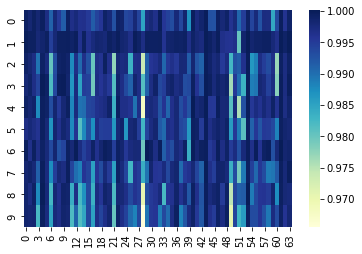

In [ ]:
ax = sns.heatmap(results, cmap="YlGnBu")
plt.show()

In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print(params)

10090


In [ ]:
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
print([np.prod(p.size()) for p in model_parameters])

[144, 16, 9216, 64, 640, 10]


## In-situ Training

### Passive Crossbar

In [ ]:
"""
crossbar.py
Louis Primeau
University of Toronto Department of Electrical and Computer Engineering
louis.primeau@mail.utoronto.ca
July 29th 2020
"""
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import itertools
import time
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.io import savemat
import torchvision
import torch.optim as optim
import math
from scipy.io import savemat

# Implements scipy's minmax scaler except just between 0 and 1 for torch Tensors.
# Taken from a ptrblck post on the PyTorch forums. Love that dude.
class MinMaxScaler(object):
    def __call__(self, tensor):
        self.scale = 1.0 / (tensor.max(dim=1, keepdim=True)[0] - tensor.min(dim=1, keepdim=True)[0])
        self.min = tensor.min(dim=1, keepdim=True)[0]
        tensor.sub_(self.min).mul_(self.scale)
        return tensor
    def inverse_transform(self, tensor):
        tensor.div_(self.scale).add_(self.min)
        return tensor

In [ ]:
class ticket:
    def __init__(self, row, col, m_rows, m_cols, matrix, mat_scale_factor, crossbar, uvect, decode, inputres, outputres):
        self.row, self.col = row, col
        self.m_rows, self.m_cols = m_rows, m_cols
        self.crossbar = crossbar
        self.mat_scale_factor = mat_scale_factor
        self.matrix = matrix
        self.uvect = uvect
        self.inputres = inputres
        self.adcres = outputres
        self.decode = torch.matmul(self.uvect.t(),self.matrix)

    def prep_vector(self, vector, v_bits):

        # Scale vector to [0, 2^v_bits]
        vect_min = torch.min(vector)
        vector = vector - vect_min
        vect_scale_factor = torch.max(vector) / (2**v_bits - 1)
        vector = vector / vect_scale_factor if vect_scale_factor != 0.0 else vector

        # decompose vector by bit
        bit_vector = torch.zeros(vector.size(0),v_bits)
        bin2s = lambda x : ''.join(reversed( [str((int(x) >> i) & 1) for i in range(v_bits)] ) )
        for j in range(vector.size(0)):
            bit_vector[j,:] = torch.Tensor([float(i) for i in list(bin2s(vector[j]))])
        bit_vector *= self.crossbar.V

        # Pad bit vector with unselected voltages
        pad_vector = torch.zeros(self.crossbar.size[0], v_bits)

        pad_vector[self.row:self.row + self.m_rows,:] = bit_vector

        return pad_vector, vect_scale_factor, vect_min

    def vmm(self, vector):
        # Baseline VMM operation without CODEX
        v_bits = self.inputres
        assert vector.size(1) == 1, "vector wrong shape"

        crossbar = self.crossbar
        # Rescale vector and convert to bits.
        pad_vector, vect_scale_factor, vect_min = self.prep_vector(vector, v_bits)

        rW = self.crossbar.W[0:(self.matrix.shape[0]),0:(2*self.matrix.shape[1])]
        rW = rW[:,1::2] - rW[:,0::2]

        # Perform crossbar VMM
        rV = torch.transpose(pad_vector[0:vector.size(0)],0,1)
        rout = torch.matmul(rV, rW)

        # Round rout to input ADC resolution
        rout_scale_factor = torch.max(rout) / (2**self.adcres - 1)
        rout = rout / rout_scale_factor
        rout = torch.round(rout)
        rout = rout * rout_scale_factor

        # Add binary outputs
        for i in range(rout.size(0)):
            rout[i] *= 2**(v_bits - i - 1)
        rout = torch.sum(rout, axis=0)

        # Rescale binary outputs
        rout = (rout / crossbar.V * vect_scale_factor*self.mat_scale_factor) / 1.5131 + torch.sum(vect_min*self.matrix,axis=0)
        return rout.view(-1,1)

    def CODEXvmm(self, xvector):
        # CODEX VMM operation
        assert xvector.size(1) == 1, "vector wrong shape"
        v_bits=self.inputres
        crossbar = self.crossbar

        #Add encoding vector u to x
        vector = xvector + self.uvect
        pad_vector, vect_scale_factor, vect_min = self.prep_vector(vector, v_bits+1)

        rW = self.crossbar.W[0:(self.matrix.shape[0]),0:(2*self.matrix.shape[1])]
        rW = rW[:,1::2] - rW[:,0::2]

        rV = torch.transpose(pad_vector[0:vector.size(0)],0,1)
        # The rout on the line below this comment contains
        # the raw output currents that the ADC will receive.
        rout = torch.matmul(rV, rW)

        # Round rout to input ADC resolution
        rout_scale_factor = torch.max(rout) / (2**self.adcres - 1)
        rout = rout / rout_scale_factor
        rout = torch.round(rout)
        rout = rout * rout_scale_factor

        for i in range(rout.size(0)):
            rout[i] *= 2**(v_bits - i - 1)
        rout = torch.sum(rout, axis=0)
        rout = 2*(rout / crossbar.V * vect_scale_factor*self.mat_scale_factor) / 1.5231 + torch.sum(vect_min*self.matrix,axis=0)
        rout = rout - self.decode
        return rout.view(-1,1)

    def modified_CODEXvmm(self, xvector):
        # CODEX VMM operation
        assert xvector.size(1) == 1, "vector wrong shape"
        v_bits=self.inputres
        crossbar = self.crossbar

        #Add encoding vector u to x
        vector = xvector + self.uvect
        pad_vector, vect_scale_factor, vect_min = self.prep_vector(vector, v_bits+1)

        rW = self.crossbar.W[0:(self.matrix.shape[0]),0:(2*self.matrix.shape[1])]
        rW = rW[:,1::2] - rW[:,0::2]

        rV = torch.transpose(pad_vector[0:vector.size(0)],0,1)
        # The rout on the line below this comment contains
        # the raw output currents that the ADC will receive.
        rout = torch.matmul(rV, rW)

        # Round rout to input ADC resolution
        rout_scale_factor = torch.max(rout) / (2**self.adcres - 1)
        rout = rout / rout_scale_factor
        rout = torch.round(rout)
        rout = rout * rout_scale_factor

        for i in range(rout.size(0)):
            rout[i] *= 2**(v_bits - i - 1)
        rout = torch.sum(rout, axis=0)
        rout = 2*(rout / crossbar.V * vect_scale_factor*self.mat_scale_factor) / 1.5231 + torch.sum(vect_min*self.matrix,axis=0)

        # do not decode except during inference
        # rout = rout - self.decode
        return rout.view(-1,1)

In [ ]:
import torch.optim as optim
import random
import copy

class linear(torch.autograd.Function):
    #From Louis: Custom pytorch autograd function for crossbar VMM operation
    @staticmethod
    def forward(ctx, ticket, x, W, b):
        ctx.save_for_backward(x, W, b)
        #return ticket.CODEXvmm(x) + b
        return ticket.CODEXvmm(x) + b

    @staticmethod
    def backward(ctx, dx):
        x, W, b = ctx.saved_tensors
        grad_input = W.t().mm(dx)
        grad_weight = dx.mm(x.t())
        grad_bias = dx
        return (None, grad_input, grad_weight, grad_bias)

class Linear(torch.nn.Module):
    def __init__(self, input_size, output_size, cb,uvect):
        super(Linear, self).__init__()
        self.W = torch.nn.parameter.Parameter(torch.rand(output_size, input_size))
        self.b = torch.nn.parameter.Parameter(torch.rand(output_size, 1))
        self.cb = cb

        #Instantiate Linear layer with pool of random encoding vectors to sample from
        self.uvectlist = uvect
        self.uvectidx = 0
        # Decoding vector is calculated ideally here off-chip, but calculating decoding vector on-chip is also possible
        self.decode = torch.matmul(self.uvectlist[self.uvectidx].t(),torch.transpose(self.W,0,1)).detach().clone()
        self.ticket = cb.register_linear(torch.transpose(self.W,0,1),self.uvectlist[self.uvectidx],self.decode)
        self.f = linear()
        self.cbon = False

    def forward(self, x):
        return self.f.apply(self.ticket, x, self.W, self.b) if self.cbon else self.W.matmul(x) + self.b

    def remap(self):
        #Should call the remap crossbar function after 1 or a couple update steps
        self.cb.clear()
        self.ticket = self.cb.register_linear(torch.transpose(self.W,0,1),self.uvectlist[self.uvectidx],self.decode)

    def update_decode(self):
        #Update decoding vector by updating U*G.
        self.decode = torch.matmul(self.uvectlist[self.uvectidx].t(),torch.transpose(self.W,0,1)).detach().clone()

    def resample(self):
        #Sample random new uvector from provided uvectlist
        self.cb.clear()
        self.uvectidx = random.randint(0, len(uvectlist)-1)
        self.ticket = self.cb.register_linear(torch.transpose(self.W,0,1),self.uvectlist[self.uvectidx],self.decode)

    def use_cb(self, state):
        self.cbon = state


In [ ]:
class crossbar:
    def __init__(self, device_params):

        # Power Supply Voltage
        self.V = device_params["Vdd"]

        # DAC resolution
        self.input_resolution = device_params["dac_resolution"]
        self.output_resolution = device_params["adc_resolution"]

        # Wordline Resistance
        self.r_wl = torch.Tensor((device_params["r_wl"],))
        # Bitline Resistance
        self.r_bl = torch.Tensor((device_params["r_bl"],))

        # Number of rows, columns
        self.size = device_params["m"], device_params["n"]

        # High resistance state
        self.g_on = 1 / torch.normal(device_params["r_on_mean"], device_params["r_on_stddev"], size=self.size)
        #self.g_on = (1 / device_params["r_on_mean"]) * torch.ones(self.size)

        # Low Resistance state
        self.g_off = 1 / torch.normal(device_params["r_off_mean"], device_params["r_off_stddev"], size=self.size)
        #self.g_off = (1 / device_params["r_off_mean"]) * torch.ones(self.size)

        self.g_wl = torch.Tensor((1 / device_params["r_wl"],))
        self.g_bl = torch.Tensor((1 / device_params["r_bl"],))

        # Resolution
        self.resolution = device_params["device_resolution"]
        # Conductance tensor, m x n x 2**resolution

        # 2**self.resolution - 1 so that there's a conductance state in the middle.
        self.conductance_states = torch.cat([torch.cat([torch.linspace(self.g_off[i,j], self.g_on[i,j],2**self.resolution - 1).unsqueeze(0)
                                                        for j in range(self.size[1])],dim=0).unsqueeze(0)
                                             for i in range(self.size[0])],dim=0)

        # Bias Scheme
        self.bias_voltage = self.V * device_params["bias_scheme"]

        # Tile size (1x1 = 1T1R, nxm = passive, etc.)
        self.tile_rows = device_params["tile_rows"]
        self.tile_cols = device_params["tile_cols"]
        assert self.size[0] % self.tile_rows == 0, "tile size does not divide crossbar size in row direction"
        assert self.size[1] % self.tile_cols == 0, "tile size does not divide crossbar size in col direction"

        # Resistance of CMOS lines
        self.r_cmos_line = device_params["r_cmos_line"]

        # Conductance Matrix; initialize each memristor at the on resstance
        self.W = torch.ones(self.size) * self.g_on

        # Stuck-on & stuck-on device nonideality
        self.p_stuck_on = device_params["p_stuck_on"]
        self.p_stuck_off = device_params["p_stuck_off"]
        self.devicefaults = False

        self.mapped = []

        self.saved_tiles = {}

    def apply_stuck(self, p_stuck_on, p_stuck_off):

        state_dist = torch.distributions.categorical.Categorical(probs=torch.Tensor([p_stuck_on, p_stuck_off, 1 - p_stuck_on - p_stuck_off]))
        state_mask = state_dist.sample(self.size)

        self.W[state_mask == 0] = self.g_off[state_mask==0]
        self.W[state_mask == 1] = self.g_on[state_mask==1]

        return None

    def map(self, matrix):
        assert not(matrix.size(0) > self.size[0] or matrix.size(1)*2 > self.size[1]), "input too large"
        midpoint = self.conductance_states.size(2) // 2

        for i in range(matrix.size(0)):
            for j in range(matrix.size(1)):

                shifted = self.conductance_states[i,j] - self.conductance_states[i,j,midpoint]
                idx = torch.min(torch.abs(shifted - matrix[i,j]), dim=0)[1]

                self.W[i,2*j+1] = self.conductance_states[i,j,idx]
                self.W[i,2*j] = self.conductance_states[i,j,midpoint-(idx-midpoint)]

    def solve(self, voltage):
        output = torch.zeros((voltage.size(1), self.size[1]))
        for i in range(self.size[0] // self.tile_rows):
            for j in range(self.size[1] // self.tile_cols):
                for k in range(voltage.size(1)):
                    coords = (i*self.tile_rows, (i+1)*self.tile_rows, j*self.tile_cols, (j+1)*self.tile_rows)
                    vect = voltage[i*self.tile_rows:(i+1)*self.tile_rows,k]
                    solution = self.circuit_solve(coords, vect, torch.zeros(self.size[1]), torch.ones(self.size[1]), torch.zeros(self.size[0]))
                    output[k] += torch.cat((torch.zeros(j*self.tile_cols), solution, torch.zeros((self.size[1] // self.tile_cols - j - 1) * self.tile_cols)))
        return output

    """
    A Comprehensive Crossbar Array Model With Solutions for Line Resistance and Nonlinear Device Characteristics
    An Chen
    IEEE TRANSACTIONS ON ELECTRON DEVICES, VOL. 60, NO. 4, APRIL 2013
    """

    def hash_M(self, a, b, c, d):
        return str(a) + "_" + str(b) + "_" + str(c) + "_" + str(d)

    def make_M(self, a, b, c, d):

        conductances = self.W[a:b,c:d]
        g_wl, g_bl = self.g_wl, self.g_bl
        g_s_wl_in, g_s_wl_out = torch.ones(self.tile_rows) * 1, torch.ones(self.tile_rows) * 1e-9
        g_s_bl_in, g_s_bl_out = torch.ones(self.tile_rows) * 1e-9, torch.ones(self.tile_rows) * 1
        m, n = self.tile_rows, self.tile_cols

        A = torch.block_diag(*tuple(torch.diag(conductances[i,:])
                          + torch.diag(torch.cat((g_wl, g_wl * 2 * torch.ones(n-2), g_wl)))
                          + torch.diag(g_wl * -1 *torch.ones(n-1), diagonal = 1)
                          + torch.diag(g_wl * -1 *torch.ones(n-1), diagonal = -1)
                          + torch.diag(torch.cat((g_s_wl_in[i].view(1), torch.zeros(n - 2), g_s_wl_out[i].view(1))))
                                   for i in range(m)))

        B = torch.block_diag(*tuple(-torch.diag(conductances[i,:]) for i in range(m)))

        def makec(j):
            c = torch.zeros(m, m*n)
            for i in range(m):
                c[i,n*(i) + j] = conductances[i,j]
            return c

        C = torch.cat([makec(j) for j in range(n)],dim=0)

        def maked(j):
            d = torch.zeros(m, m*n)

            def c(k):
                return(k - 1)

            i = 1
            d[c(i),c(j)] = -g_s_bl_in[c(j)] - g_bl - conductances[c(i),c(j)]
            d[c(i), n*i + c(j)] = g_bl

            i = m
            d[c(i), n*(i-2) + c(j)] = g_bl
            d[c(i), n*(i-1) + c(j)] = -g_s_bl_out[c(j)] - conductances[c(i),c(j)] - g_bl

            for i in range(2, m):
                d[c(i), n*(i-2) + c(j)] = g_bl
                d[c(i), n*(i-1) + c(j)] = -g_bl - conductances[c(i),c(j)] - g_bl
                d[c(i), n*(i+1) + c(j)] = g_bl

            return d

        D = torch.cat([maked(j) for j in range(1,n+1)], dim=0)

        M = torch.cat((torch.cat((A,B),dim=1), torch.cat((C,D),dim=1)), dim=0)

        self.saved_tiles[self.hash_M(a,b,c,d)] = M

        return torch.inverse(M)

    def circuit_solve(self, coords,  v_wl_in, v_bl_in, v_bl_out, v_wl_out):

        g_wl, g_bl = self.g_wl, self.g_bl
        g_s_wl_in, g_s_wl_out = torch.ones(self.tile_rows) * 1, torch.ones(self.tile_rows) * 1e-9
        g_s_bl_in, g_s_bl_out = torch.ones(self.tile_rows) * 1e-9, torch.ones(self.tile_rows) * 1
        m, n = self.tile_rows, self.tile_cols


        if self.hash_M(*coords) not in self.saved_tiles.keys():
            #print(coords)
            M = self.make_M(*coords)
        else:
            M = self.saved_tiles[self.hash_M(*coords)]

        E = torch.cat([torch.cat(((v_wl_in[i]*g_s_wl_in[i]).view(1), #EW
                                  torch.zeros(n-2),
                                  (v_wl_out[i]*g_s_wl_out[i]).view(1)))
                                 for i in range(m)] +
                      [torch.cat(((-v_bl_in[i]*g_s_bl_in[i]).view(1), #EB
                                  torch.zeros(m-2),
                                  (-v_bl_in[i]*g_s_bl_out[i]).view(1)))
                                 for i in range(n)]
        ).view(-1, 1)

        V = torch.matmul(M, E)

        V = torch.chunk(torch.solve(E, M)[0], 2)

        return torch.sum((V[1] - V[0]).view(m,n)*self.W[coords[0]:coords[1],coords[2]:coords[3]],dim=0)

    def register_linear(self, matrix, uvectlist, decode, bias=None):

        row, col = self.find_space(matrix.size(0), matrix.size(1))
        # Need to add checks for bias size and col size

        # Scale matrix
        mat_scale_factor = torch.max(torch.abs(matrix)) / torch.max(self.g_on) * 2
        scaled_matrix = matrix / mat_scale_factor

        midpoint = self.conductance_states.size(2) // 2
        for i in range(row, row + scaled_matrix.size(0)):
            for j in range(col, col + scaled_matrix.size(1)):

                shifted = self.conductance_states[i,j] - self.conductance_states[i,j,midpoint]
                idx = torch.min(torch.abs(shifted - scaled_matrix[i-row,j-col]), dim=0)[1]
                self.W[i,2*j+1] = self.conductance_states[i,j,idx]
                self.W[i,2*j] = self.conductance_states[i,j,midpoint-(idx-midpoint)]

        return ticket(row, col, matrix.size(0), matrix.size(1), matrix, mat_scale_factor, self, uvectlist, decode, self.input_resolution, self.output_resolution)

    def which_tiles(self, row, col, m_row, m_col):
        return itertools.product(range(row // self.tile_rows, (row + m_row) // self.tile_rows + 1),
                                 range(col // self.tile_cols,(col + m_col) // self.tile_cols + 1),
        )

    def find_space(self, m_row, m_col):
        if not self.mapped:
            self.mapped.append((0,0,m_row,m_col))
        else:
            self.mapped.append((self.mapped[-1][0] + self.mapped[-1][2], self.mapped[-1][1] + self.mapped[-1][3], m_row, m_col))
        return self.mapped[-1][0], self.mapped[-1][1]

    def clear(self):
        self.mapped = []
        self.W = torch.ones(self.size) * self.g_on

    def conductance_update(self):
        self.conductance_states = torch.cat([torch.cat([torch.linspace(self.g_off[i,j], self.g_on[i,j],2**self.resolution - 1).unsqueeze(0)
                                                        for j in range(self.size[1])],dim=0).unsqueeze(0)
                                             for i in range(self.size[0])],dim=0)


In [ ]:
# Key Idea is that CODEX allows us to use higher ADC inpt resolution by
# Reducing the ADC sensing range.
device_params = {"Vdd": 1.8,
                 "r_wl": 10,
                 "r_bl": 10,
                 "m": 600,
                 "n": 600,
                 "r_on_mean": 1e4,
                 "r_on_stddev": 1e3,
                 "r_off_mean": 1e5,
                 "r_off_stddev": 1e4,
                 "dac_resolution": 5,
                 "adc_resolution": 8.3,
                 "device_resolution": 8,
                 "bias_scheme": 1/3,
                 "tile_rows": 4,
                 "tile_cols": 4,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "p_stuck_on": 0.01,
                 "p_stuck_off": 0.01}

In [ ]:
def network_tester(model, test_loader, test_size, epoch, log = True):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            if batch_idx * len(data) > test_size:
                break
            output = model(data)
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            total+=target.size(0)
            loss = F.nll_loss(output, target)

            test_loss += loss.item()

            if batch_idx % test_size == 0 and log:
              with open('log_baseline_test.csv', 'a') as f:
                writer = csv.writer(f)
                writer.writerow([batch_idx + test_size * 100, test_loss/(batch_idx+1), correct.item()/total])
              print("Epoch", epoch, 'iteration',batch_idx, 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                          % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    return torch.div(correct, float(total))

### SGD only training

In [ ]:
def net_trainer(model, train_dataloader, test_dataloader, config):
    model.train()
    avg_loss = -1
    optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum'])

    torch.manual_seed(0)
    update_per_epoch = []
    loss_per_epoch = []
    every_loss = []
    thr_per_batch = []

    for j in range(config['num_epochs']):
        data, target = next(iter(train_dataloader))
        optimizer.zero_grad()
        # output = model(data)
        # loss = F.nll_loss(output, target)
        # loss.backward()
        # optimizer.step()
        # cur_avg_abs_grad = model.fc1.W.grad.abs().mean()
        # init_thr = local_sched(config['learning_rate'], config['gamma'],
        #                        cur_avg_abs_grad, j+1)
        # thr = init_thr
        cur_epoch_updates = 0
        for batch_idx, (data, target) in enumerate(train_dataloader):

            if batch_idx % config['test_interval'] == 1:
                print(f"Test accuracy: {network_tester(model, test_dataloader, 800, j)}")

            if batch_idx % config['log_interval'] == 1:
                print(f"Epoch: {j + 1}, Loss: {loss.data} Updates: {cur_epoch_updates}/{batch_idx}, Avg Grad: {cur_avg_abs_grad}")
                with open('log_baseline_train.csv', 'a') as f:
                    writer = csv.writer(f)
                    writer.writerow([batch_idx + j * config['log_interval'], loss.data.item(), network_tester(model, train_dataloader, 100, j, False).item()])

            output = model(data)
            loss = F.nll_loss(output, target) / config['batch_size']
            loss.backward()
            every_loss.append(loss.data)

            # if avg_loss == -1.0:
            #     avg_loss = loss
            # else:
            #     avg_loss += loss
            # if avg_loss > config['naive_loss_thr']:
            #     thr = init_thr

            if batch_idx % config['batch_size'] == 0:
                cur_avg_abs_grad = model.fc1.W.grad.abs().mean()
                # this is kind of hardcoded... Are we doing num_layers in this search?
                # we want to perform searches on things that don't really affect the
                # effectivity of thresholding, so maybe not
                # perhaps let's do ADC resolution + learning rate?
                cur_epoch_updates += 1
                # cur_lr = get_current_lr(optimizer, 0, 0)
                # thr = local_sched(config['learning_rate'],
                #                                 config['gamma'], cur_avg_abs_grad, batch_idx+1)
                optimizer.step()
                model.fc1.remap()
                #netowrk.fc2.remap()
                optimizer.zero_grad()
            #     avg_loss = -1.0
            # thr_per_batch.append(thr)


        update_per_epoch.append(cur_epoch_updates)


        loss_per_epoch.append(loss.data)
    return loss_per_epoch, update_per_epoch, every_loss

### Thresholded update method

In [ ]:
def net_trainer_thresh(model, train_dataloader, test_dataloader, config):
    model.train()
    avg_loss = -1
    optimizer = optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum'])
    threshold_update = False

    def local_sched(learning_rate, gamma, cur_avg_abs_grad, epoch_n):
        new_thr = cur_avg_abs_grad*(1+(math.exp(-learning_rate*gamma*epoch_n)))
        upper_bound = cur_avg_abs_grad * config['max_thresh_multiplier']

        return min(new_thr, upper_bound)

    torch.manual_seed(0)
    update_per_epoch = []
    loss_per_epoch = []
    every_loss = []
    thr_per_batch = []

    for j in range(config['num_epochs']):
        data, target = next(iter(train_dataloader))
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        cur_avg_abs_grad = model.fc1.W.grad.abs().mean()
        init_thr = local_sched(config['learning_rate'], config['gamma'],
                               cur_avg_abs_grad, j+1)
        thr = init_thr
        cur_epoch_updates = 0
        for batch_idx, (data, target) in enumerate(train_dataloader):

            if batch_idx % config['test_interval'] == 1:
                print(f"Test accuracy: {network_tester(model, test_dataloader, 800, j)}")

            if batch_idx % config['log_interval'] == 1:
                print(f"Epoch: {j + 1}, Loss: {loss.data} Updates: {cur_epoch_updates}/{batch_idx}, Avg Grad: {cur_avg_abs_grad}, Threshold: {thr}")
                with open('log_baseline_train.csv', 'a') as f:
                  writer = csv.writer(f)
                  writer.writerow([batch_idx + j * config['log_interval'], loss.data.item(), network_tester(model, train_dataloader, 100, j, False).item()])

            output = model(data)
            loss = F.nll_loss(output, target) / config['batch_size']
            loss.backward()
            every_loss.append(loss.data)

            if avg_loss == -1.0:
                avg_loss = loss
            else:
                avg_loss += loss
            # if avg_loss > config['naive_loss_thr']:
            #     thr = init_thr

            if batch_idx % config['batch_size'] == 0:
                cur_avg_abs_grad = model.fc1.W.grad.abs().mean()
                if threshold_update:
                    thr = local_sched(config['learning_rate'],
                                                    config['gamma'], cur_avg_abs_grad, batch_idx+1)
                    threshold_update = False
                # this is kind of hardcoded... Are we doing num_layers in this search?
                # we want to perform searches on things that don't really affect the
                # effectivity of thresholding, so maybe not
                # perhaps let's do ADC resolution + learning rate?
                if cur_avg_abs_grad > thr:
                    cur_epoch_updates += 1
                    # cur_lr = get_current_lr(optimizer, 0, 0)
                    # thr = local_sched(config['learning_rate'],
                    #                                 config['gamma'], cur_avg_abs_grad, batch_idx+1)
                    optimizer.step()
                    model.fc1.remap()
                    #netowrk.fc2.remap()
                    optimizer.zero_grad()
                    threshold_update = True
                avg_loss = -1.0
                thr_per_batch.append(thr)


        update_per_epoch.append(cur_epoch_updates)


        loss_per_epoch.append(loss.data)
    return loss_per_epoch, update_per_epoch, every_loss, thr_per_batch

### Manhattan learning rule

In [ ]:
import csv
def net_trainer_manh(model, train_dataloader, test_dataloader, config):
    model.train()
    avg_loss = -1
    optimizer = ManhattanSGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum'], dampening=config['dampening'])
    #optim.SGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum'])

    torch.manual_seed(0)
    update_per_epoch = []
    loss_per_epoch = []
    every_loss = []
    thr_per_batch = []

    for j in range(config['num_epochs']):
        data, target = next(iter(train_dataloader))
        optimizer.zero_grad()
        # output = model(data)
        # loss = F.nll_loss(output, target)
        # loss.backward()
        # optimizer.step()
        # cur_avg_abs_grad = model.fc1.W.grad.abs().mean()
        # init_thr = local_sched(config['learning_rate'], config['gamma'],
        #                        cur_avg_abs_grad, j+1)
        # thr = init_thr
        cur_epoch_updates = 0
        for batch_idx, (data, target) in enumerate(train_dataloader):

            if batch_idx % config['test_interval'] == 1:
                print(f"Test accuracy: {network_tester(model, test_dataloader, 800, j)}")

            if batch_idx % config['log_interval'] == 1:
                print(f"Epoch: {j + 1}, Loss: {loss.data} Updates: {cur_epoch_updates}/{batch_idx}, Avg Grad: {cur_avg_abs_grad}")
                with open('log_baseline_train.csv', 'a') as f:
                    writer = csv.writer(f)
                    writer.writerow([batch_idx + j * config['log_interval'], loss.data.item(), network_tester(model, train_dataloader, 400, j, False).item()])

            output = model(data)
            loss = F.nll_loss(output, target) / config['batch_size']
            loss.backward()
            every_loss.append(loss.data)


            if batch_idx % config['batch_size'] == 0:
                cur_avg_abs_grad = model.fc1.W.grad.abs().mean()
                # this is kind of hardcoded... Are we doing num_layers in this search?
                # we want to perform searches on things that don't really affect the
                # effectivity of thresholding, so maybe not
                # perhaps let's do ADC resolution + learning rate?
                cur_epoch_updates += 1

                optimizer.step()
                model.fc1.remap()
                #netowrk.fc2.remap()
                optimizer.zero_grad()
            #     avg_loss = -1.0
            # thr_per_batch.append(thr)


        update_per_epoch.append(cur_epoch_updates)


        loss_per_epoch.append(loss.data)
    return loss_per_epoch, update_per_epoch, every_loss

### Training Code

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3, 3)
        self.conv2 = nn.Conv2d(16, 64, 3, 3)
       # self.conv3 = nn.Conv2d(16, 32, 2, 2)
        #self.fc1 = nn.Linear(9216, 10)

        # self.linear = nn.Linear(512*block.expansion, num_classes)
        self.uvect = [2*(torch.rand(64,1) - 0.5) for i in range(0,10)] #
        crb1 = crossbar(device_params)
        # Can test using more than 1 crossbar linear layers.
        # Easiest implementation is to create a crossbar for each linear layer
        self.fc1 = Linear(64, 10,crb1,self.uvect)
        self.fc1.use_cb(True)
        #self.fc2 = nn.Linear(64*2*2, 10)
        self.traincount = 0

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        #x = F.relu(self.conv3(x))
        out = F.max_pool2d(x, 2)

        out = out.view(64, 1)
        #print(out.shape)
        out = self.fc1(out)
        out = out.t()
        out = F.log_softmax(out)
        return out

In [ ]:
# Key Idea is that CODEX allows us to use higher ADC inpt resolution by
# Reducing the ADC sensing range.
device_params = {"Vdd": 1.8,
                 "r_wl": 10,
                 "r_bl": 10,
                 "m": 100,
                 "n": 100,
                 "r_on_mean": 1e4,
                 "r_on_stddev": 1e3,
                 "r_off_mean": 1e5,
                 "r_off_stddev": 1e4,
                 "dac_resolution": 5,
                 "adc_resolution": 8.3,
                 "device_resolution": 8,
                 "bias_scheme": 1/3,
                 "tile_rows": 4,
                 "tile_cols": 4,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "p_stuck_on": 0.01,
                 "p_stuck_off": 0.01}

In [ ]:
MNISTtransform = transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.1307,), (0.3081,))])

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../datasets/', train=False, download=True,
                               transform=MNISTtransform),
                               batch_size=1, shuffle=True)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../datasets/', train=True, download=True,
                               transform=MNISTtransform),
                               batch_size=1, shuffle=True)

In [ ]:
# baseline
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import csv

net_base = Net()
net_base = net_base.to(device)
if device == 'cuda':
    net_base = torch.nn.DataParallel(net_base)
    cudnn.benchmark = True

train_config = {
    "num_epochs" : 5,
    "batch_size" : 200,
    "gamma" : 1,
    "naive_loss_thr" : 2,
    'learning_rate' : 0.01, #0.002,
    "log_interval" : 1000,
    "momentum": 0.9,
    "max_thresh_multiplier": 2,
    "test_interval": 5000,
    "dampening": 0.1
}

# we know for this dataset the max n_epoch = 50,000
def calc_gamma(lr, m_epoch):
    return np.log(lr)/(-lr*m_epoch)

train_config['gamma'] = calc_gamma(train_config['learning_rate'], 50000)
#optimizer = ManhattanSGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum'])

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

with open('log_baseline_train.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["iteration", "train_loss", "train_acc"])

with open('log_baseline_test.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["iteration", "test_loss", "test_acc"])

c3f1_loss_per_epoch, c3f1_update_per_epoch, c3f1_every_loss = net_trainer(net_base, train_loader, test_loader, train_config)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0 iteration 0 Loss: 3.784 | Acc: 0.000% (0/1)
Epoch 0 iteration 800 Loss: 3.646 | Acc: 8.614% (69/801)
Test accuracy: 0.08614232391119003
Epoch: 1, Loss: 0.0018906896002590656 Updates: 1/1, Avg Grad: 8.64160101627931e-05
Epoch: 1, Loss: 0.010919912718236446 Updates: 6/1001, Avg Grad: 0.01361001469194889
Epoch: 1, Loss: 0.022612689062952995 Updates: 11/2001, Avg Grad: 0.017039235681295395
Epoch: 1, Loss: 0.010265294462442398 Updates: 16/3001, Avg Grad: 0.012855246663093567
Epoch: 1, Loss: 0.009833801537752151 Updates: 21/4001, Avg Grad: 0.013128605671226978
Epoch 0 iteration 0 Loss: 1.947 | Acc: 0.000% (0/1)
Epoch 0 iteration 800 Loss: 1.592 | Acc: 47.316% (379/801)
Test accuracy: 0.4731585383415222
Epoch: 1, Loss: 0.013807320967316628 Updates: 26/5001, Avg Grad: 0.01917598582804203
Epoch: 1, Loss: 0.007337197195738554 Updates: 31/6001, Avg Grad: 0.01796833612024784
Epoch: 1, Loss: 0.0021184468641877174 Updates: 36/7001, Avg Grad: 0.01700310781598091
Epoch: 1, Loss: 0.010060545057

In [ ]:
# baseline 2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import csv

net = Net()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

train_config = {
    "num_epochs" : 5,
    "batch_size" : 200,
    "gamma" : 1,
    "naive_loss_thr" : 2,
    'learning_rate' : 0.01, #0.002,
    "log_interval" : 1000,
    "momentum": 0.9,
    "max_thresh_multiplier": 2,
    "test_interval": 5000,
    "dampening": 0.1
}

# we know for this dataset the max n_epoch = 50,000
def calc_gamma(lr, m_epoch):
    return np.log(lr)/(-lr*m_epoch)

train_config['gamma'] = calc_gamma(train_config['learning_rate'], 50000)
#optimizer = ManhattanSGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum'])

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

with open('log_baseline_train.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["iteration", "train_loss", "train_acc"])

with open('log_baseline_test.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["iteration", "test_loss", "test_acc"])

c3f1_loss_per_epoch, c3f1_update_per_epoch, c3f1_every_loss = net_trainer(net, train_loader, test_loader, train_config)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0 iteration 0 Loss: 2.568 | Acc: 0.000% (0/1)
Epoch 0 iteration 800 Loss: 2.985 | Acc: 10.861% (87/801)
Test accuracy: 0.1086142286658287
Epoch: 1, Loss: 0.030000319704413414 Updates: 1/1, Avg Grad: 0.0002007457660511136
Epoch: 1, Loss: 0.008897189050912857 Updates: 6/1001, Avg Grad: 0.012411796487867832
Epoch: 1, Loss: 0.020243948325514793 Updates: 11/2001, Avg Grad: 0.018086981028318405
Epoch: 1, Loss: 0.006830353755503893 Updates: 16/3001, Avg Grad: 0.01565719209611416
Epoch: 1, Loss: 0.011096806265413761 Updates: 21/4001, Avg Grad: 0.014740079641342163
Epoch 0 iteration 0 Loss: 2.359 | Acc: 0.000% (0/1)
Epoch 0 iteration 800 Loss: 1.428 | Acc: 57.179% (458/801)
Test accuracy: 0.5717852711677551
Epoch: 1, Loss: 0.008951055817306042 Updates: 26/5001, Avg Grad: 0.014473247341811657
Epoch: 1, Loss: 0.007621733006089926 Updates: 31/6001, Avg Grad: 0.016578882932662964
Epoch: 1, Loss: 0.0008220408344641328 Updates: 36/7001, Avg Grad: 0.017875786870718002
Epoch: 1, Loss: 0.007150381

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import csv

net = Net()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

train_config = {
    "num_epochs" : 10,
    "batch_size" : 200,
    "gamma" : 1,
    "naive_loss_thr" : 2,
    'learning_rate' : 0.0004, #0.002,
    "log_interval" : 1000,
    "momentum": 0.9,
    "max_thresh_multiplier": 2,
    "test_interval": 5000,
    "dampening": 0.1
}

# we know for this dataset the max n_epoch = 50,000
def calc_gamma(lr, m_epoch):
    return np.log(lr)/(-lr*m_epoch)

train_config['gamma'] = calc_gamma(train_config['learning_rate'], 50000)
#optimizer = ManhattanSGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum'])

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

with open('log_baseline_train.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["iteration", "train_loss", "train_acc"])

with open('log_baseline_test.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["iteration", "test_loss", "test_acc"])

c3f1_loss_per_epoch, c3f1_update_per_epoch, c3f1_every_loss = net_trainer_manh(net, train_loader, test_loader, train_config)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:82: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1174.)


Epoch 0 iteration 0 Loss: 2.688 | Acc: 0.000% (0/1)
Epoch 0 iteration 400 Loss: 2.931 | Acc: 12.219% (49/401)
Test accuracy: 0.12219451367855072
Epoch: 1, Loss: 0.030000319704413414 Updates: 1/1, Avg Grad: 0.0002007457660511136
Epoch: 1, Loss: 0.01132808718830347 Updates: 6/1001, Avg Grad: 0.014153003692626953
Epoch: 1, Loss: 0.022904105484485626 Updates: 11/2001, Avg Grad: 0.012635499238967896
Epoch: 1, Loss: 0.00916460994631052 Updates: 16/3001, Avg Grad: 0.013610957190394402
Epoch: 1, Loss: 0.010731346905231476 Updates: 21/4001, Avg Grad: 0.014077511616051197
Epoch 0 iteration 0 Loss: 2.300 | Acc: 0.000% (0/1)
Epoch 0 iteration 400 Loss: 2.370 | Acc: 27.182% (109/401)
Test accuracy: 0.27182045578956604
Epoch: 1, Loss: 0.0108350133523345 Updates: 26/5001, Avg Grad: 0.013668161816895008
Epoch: 1, Loss: 0.011185097508132458 Updates: 31/6001, Avg Grad: 0.012205793522298336
Epoch: 1, Loss: 0.01580694690346718 Updates: 36/7001, Avg Grad: 0.01156819798052311
Epoch: 1, Loss: 0.0134686306118

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms

import os
import argparse
import csv

net = Net()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

train_config = {
    "num_epochs" : 10,
    "batch_size" : 200,
    "gamma" : 1,
    "naive_loss_thr" : 2,
    'learning_rate' : 0.0008, #0.002,
    "log_interval" : 1000,
    "momentum": 0.9,
    "max_thresh_multiplier": 2,
    "test_interval": 5000,
    "dampening": 0.1
}

# we know for this dataset the max n_epoch = 50,000
def calc_gamma(lr, m_epoch):
    return np.log(lr)/(-lr*m_epoch)

train_config['gamma'] = calc_gamma(train_config['learning_rate'], 50000)
#optimizer = ManhattanSGD(model.parameters(), lr=config['learning_rate'], momentum=config['momentum'])

#scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

with open('log_baseline_train.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["iteration", "train_loss", "train_acc"])

with open('log_baseline_test.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["iteration", "test_loss", "test_acc"])

c3f1_loss_per_epoch, c3f1_update_per_epoch, c3f1_every_loss = net_trainer_manh(net, train_loader, test_loader, train_config)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0 iteration 0 Loss: 2.717 | Acc: 0.000% (0/1)
Epoch 0 iteration 400 Loss: 2.980 | Acc: 9.975% (40/401)
Test accuracy: 0.09975062310695648
Epoch: 1, Loss: 0.010539717972278595 Updates: 1/1, Avg Grad: 0.00018276847549714148
Epoch: 1, Loss: 0.015597233548760414 Updates: 6/1001, Avg Grad: 0.013224968686699867
Epoch: 1, Loss: 0.005111351143568754 Updates: 11/2001, Avg Grad: 0.011806713417172432
Epoch: 1, Loss: 0.019504191353917122 Updates: 16/3001, Avg Grad: 0.015482621267437935
Epoch: 1, Loss: 0.009258979931473732 Updates: 21/4001, Avg Grad: 0.011901721358299255
Epoch 0 iteration 0 Loss: 1.505 | Acc: 100.000% (1/1)
Epoch 0 iteration 400 Loss: 1.721 | Acc: 51.870% (208/401)
Test accuracy: 0.5187032222747803
Epoch: 1, Loss: 0.012585039250552654 Updates: 26/5001, Avg Grad: 0.010591374710202217
Epoch: 1, Loss: 0.01211595069617033 Updates: 31/6001, Avg Grad: 0.01125903520733118
Epoch: 1, Loss: 0.0016215718351304531 Updates: 36/7001, Avg Grad: 0.010116511024534702
Epoch: 1, Loss: 0.0092887

In [ ]:
net = Net()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

train_config = {
    "num_epochs" : 10,
    "batch_size" : 200,
    "gamma" : 1,
    "naive_loss_thr" : 2,
    'learning_rate' : 0.002,
    "log_interval" : 1000,
    "momentum": 0.9,
    "max_thresh_multiplier": 1.1,
    "test_interval": 10000,
}

# we know for this dataset the max n_epoch = 50,000
def calc_gamma(lr, m_epoch):
    return np.log(lr)/(-lr*m_epoch)

train_config['gamma'] = calc_gamma(train_config['learning_rate'], train_config['num_epochs'])

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)

with open('log_baseline_train.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["iteration", "train_loss", "train_acc"])

with open('log_baseline_test.csv', 'w') as f:
        writer = csv.writer(f)
        writer.writerow(["iteration", "test_loss", "test_acc"])

c3f1_loss_per_epoch, c3f1_update_per_epoch, c3f1_every_loss, c3f1_thr_per_batch = net_trainer_thresh(net, train_loader, test_loader, train_config)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch 0 iteration 0 Loss: 4.043 | Acc: 0.000% (0/1)
Epoch 0 iteration 300 Loss: 3.299 | Acc: 11.296% (34/301)
Test accuracy: 0.11295680701732635
Epoch: 1, Loss: 0.012542717158794403 Updates: 0/1, Avg Grad: 0.04362868517637253, Threshold: 0.04799661785364151
Epoch: 1, Loss: 0.01890617422759533 Updates: 3/1001, Avg Grad: 0.04069722443819046, Threshold: 0.02095271833240986
Epoch: 1, Loss: 0.003106564050540328 Updates: 5/2001, Avg Grad: 0.017455432564020157, Threshold: 0.017455432564020157
Epoch: 1, Loss: 0.0068766032345592976 Updates: 8/3001, Avg Grad: 0.029509222134947777, Threshold: 0.01559042651206255
Epoch: 1, Loss: 0.015387486666440964 Updates: 10/4001, Avg Grad: 0.016506098210811615, Threshold: 0.016506098210811615
Epoch: 1, Loss: 0.013609370216727257 Updates: 13/5001, Avg Grad: 0.02910209633409977, Threshold: 0.015135715715587139
Epoch: 1, Loss: 0.018048569560050964 Updates: 15/6001, Avg Grad: 0.013680703938007355, Threshold: 0.013680703938007355
Epoch: 1, Loss: 0.01240183319896459

## in-situ robustness

In [ ]:
net = net_base

In [ ]:
org_net_weight = net.fc1.W
org_net_bias = net.fc1.b

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


original accuracy:  0.9250936508178711 %
[[0.7260458686371879, 0.7058029588745102, 0.6720647329827604, 0.7125506169390463, 0.681511467159297, 0.7004048710814397, 0.6936572130169035, 0.682860972999832, 0.6842105432712975, 0.6788123910472964, 0.7031038827625097, 0.6869095549523675, 0.7004048710814397, 0.6869095549523675, 0.7058029588745102, 0.7125506169390463, 0.7152496286201163, 0.6545208993320832, 0.7125506169390463, 0.6963562891289041, 0.6990553008099741, 0.7004048710814397, 0.7165991988915819, 0.7058029588745102, 0.7031038827625097, 0.6990553008099741, 0.688259125223833, 0.7179487047321168, 0.7165991988915819, 0.7031038827625097, 0.7071524647150452, 0.7004048710814397, 0.6869095549523675, 0.6950067188574386, 0.6842105432712975, 0.6653171393491548, 0.7246963627966528, 0.7192982105726518, 0.7139001227795813, 0.7192982105726518], [0.7651821823220083, 0.7543859423049366, 0.7719298403865443, 0.7624831062100077, 0.7098515408270457, 0.7584345242574722, 0.7462887783998656, 0.740890690606795,

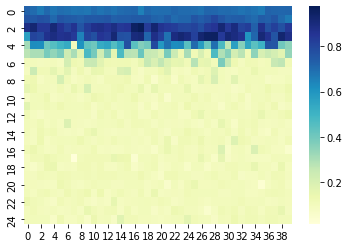

In [ ]:
wire_R = [(i+1)*2 for i in range(40)]
p_stuck = [0.01*(i) for i in range(40)]
R_std = [1e2*i for i in range(1, 101, 4)]


org_net_weight = net.fc1.W
org_net_bias = net.fc1.b

err_org = network_tester(net, test_loader, 800, 0, False).item()
print("original accuracy: ",err_org,"%")

result = []

for std in R_std:
    result_wire = []
    for var in p_stuck:
        device_params = {"Vdd": 1.8,
                 "r_wl": 20,
                 "r_bl": 20,
                 "m": 100,
                 "n": 100,
                 "r_on_mean": 1e4,
                 "r_on_stddev": std,
                 "r_off_mean": 1e5,
                 "r_off_stddev": std*10,
                 "dac_resolution": 5,
                 "adc_resolution": 8.3,
                 "device_resolution": 6,
                 "bias_scheme": 1/3,
                 "tile_rows": 4,
                 "tile_cols": 4,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "p_stuck_on": var,
                 "p_stuck_off": var}
        crb_new = crossbar(device_params)

        net.fc1.W = torch.nn.parameter.Parameter(org_net_weight)
        net.fc1.b = torch.nn.parameter.Parameter(org_net_bias)

        net.fc1.cb = crb_new
        net.fc1.remap()

        err = network_tester(net, test_loader, 800, 0, False).item()
        result_wire.append(err/err_org)

    result.append(result_wire)

print(result)
with open("result_non_ideal_CNN_base.txt", 'w') as writefile:
    writefile.write(str(result))

ax = sns.heatmap(result, cmap="YlGnBu")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


original accuracy:  0.9250936508178711 %
[[0.5991902578371207, 0.5978407519965857, 0.6032388397896562, 0.5883940822509796, 0.5829959300269785, 0.5910930939320496, 0.6126855739661928, 0.5856950061389791, 0.6099864978541922, 0.6018893339491213, 0.5910930939320496, 0.6113360036947273, 0.5978407519965857, 0.5964912461560506, 0.5937921700440502, 0.6167341559187284, 0.6018893339491213, 0.5748987661219075, 0.5735492602813724, 0.6072874217421917, 0.5748987661219075, 0.6153845856472628, 0.5748987661219075, 0.6005398281085862, 0.5951416758845851, 0.5641025261048358, 0.6423751534744766, 0.5641025261048358, 0.6099864978541922, 0.6086369920136573, 0.5951416758845851, 0.6140350798067278, 0.6032388397896562, 0.6005398281085862, 0.6086369920136573, 0.5587044383117653, 0.6086369920136573, 0.5641025261048358, 0.5668016022168364, 0.6234817495523339], [0.7354925383827939, 0.7179487047321168, 0.7557354481454717, 0.7152496286201163, 0.7759784223390799, 0.7665316881625432, 0.7786774340201499, 0.7381916144947

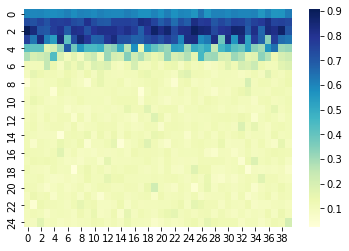

In [ ]:
wire_R = [(i+1)*2 for i in range(40)]
p_stuck = [0.01*(i) for i in range(40)]
R_std = [1e2*i for i in range(1, 101, 4)]


org_net_weight = net.fc1.W
org_net_bias = net.fc1.b

err_org = network_tester(net, test_loader, 800, 0, False).item()
print("original accuracy: ",err_org,"%")

result = []

for std in R_std:
    result_wire = []
    for var in p_stuck:
        device_params = {"Vdd": 1.8,
                 "r_wl": 20,
                 "r_bl": 20,
                 "m": 100,
                 "n": 100,
                 "r_on_mean": 1e4,
                 "r_on_stddev": std,
                 "r_off_mean": 1e5,
                 "r_off_stddev": std*10,
                 "dac_resolution": 5,
                 "adc_resolution": 8.3,
                 "device_resolution": 6,
                 "bias_scheme": 1/3,
                 "tile_rows": 4,
                 "tile_cols": 4,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "p_stuck_on": var,
                 "p_stuck_off": var}
        crb_new = crossbar(device_params)

        net.fc1.W = torch.nn.parameter.Parameter(org_net_weight)
        net.fc1.b = torch.nn.parameter.Parameter(org_net_bias)

        net.fc1.cb = crb_new
        net.fc1.remap()

        err = network_tester(net, test_loader, 800, 0, False).item()
        result_wire.append(err/err_org)

    result.append(result_wire)

print(result)
with open("result_non_ideal_CNN_thresh.txt", 'w') as writefile:
    writefile.write(str(result))

ax = sns.heatmap(result, cmap="YlGnBu")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


original accuracy:  0.942571759223938 %
[[0.7576159451312245, 0.7523178908454868, 0.7748344634694029, 0.7668874452769839, 0.7350993725073085, 0.7774834906122717, 0.7589404270845651, 0.7602649090379057, 0.7602649090379057, 0.7655629633236435, 0.7509934088921463, 0.7536424360350151, 0.7390728816035179, 0.7470198997959369, 0.7443708726530679, 0.7496688637026179, 0.7483443817492774, 0.7456953546064085, 0.7907284998542405, 0.7192053361224708, 0.7324503453644396, 0.7721854363265339, 0.7947020089504501, 0.7496688637026179, 0.7523178908454868, 0.7562913999416963, 0.7629139361807745, 0.7324503453644396, 0.7748344634694029, 0.7708609543731935, 0.6980132454518952, 0.7523178908454868, 0.7721854363265339, 0.7390728816035179, 0.7642384181341151, 0.7443708726530679, 0.7496688637026179, 0.7337748273177802, 0.7033112997376331, 0.7682119272303245], [0.7205298180758113, 0.8066225362390783, 0.7576159451312245, 0.8172185815743661, 0.847682172390701, 0.8211920906705755, 0.8463576272011727, 0.854304645393591

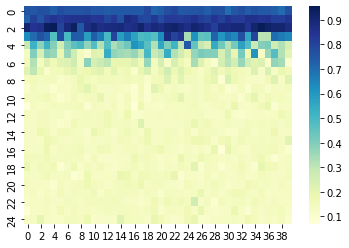

In [ ]:
wire_R = [(i+1)*2 for i in range(40)]
p_stuck = [0.01*(i) for i in range(40)]
R_std = [1e2*i for i in range(1, 101, 4)]


org_net_weight = net.fc1.W
org_net_bias = net.fc1.b

err_org = network_tester(net, test_loader, 800, 0, False).item()
print("original accuracy: ",err_org,"%")

result = []

for std in R_std:
    result_wire = []
    for var in p_stuck:
        device_params = {"Vdd": 1.8,
                 "r_wl": 20,
                 "r_bl": 20,
                 "m": 100,
                 "n": 100,
                 "r_on_mean": 1e4,
                 "r_on_stddev": std,
                 "r_off_mean": 1e5,
                 "r_off_stddev": std*10,
                 "dac_resolution": 5,
                 "adc_resolution": 8.3,
                 "device_resolution": 6,
                 "bias_scheme": 1/3,
                 "tile_rows": 4,
                 "tile_cols": 4,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "p_stuck_on": var,
                 "p_stuck_off": var}
        crb_new = crossbar(device_params)

        net.fc1.W = torch.nn.parameter.Parameter(org_net_weight)
        net.fc1.b = torch.nn.parameter.Parameter(org_net_bias)

        net.fc1.cb = crb_new
        net.fc1.remap()

        err = network_tester(net, test_loader, 800, 0, False).item()
        result_wire.append(err/err_org)

    result.append(result_wire)

print(result)
with open("result_non_ideal_CNN_manh.txt", 'w') as writefile:
    writefile.write(str(result))

ax = sns.heatmap(result, cmap="YlGnBu")
plt.show()

In [ ]:
torch.save(model.state_dict(), "model_mnistl.pth")

In [ ]:
state_dict = torch.load('model_mnistl.pth')
temp_model = Net_ex()
temp_model.load_state_dict(torch.load('model_mnistl.pth'))

<All keys matched successfully>

**Note:**
Running the cell below will end up with a Runtime Error, but all the data needed have been loaded successfully to the model.

In [ ]:
state_dict = torch.load('model_mnistl.pth')
model = Net()
model.load_state_dict(torch.load('model_mnistl.pth'))

RuntimeError: ignored

In [ ]:
# crossbar update
device_params = {"Vdd": 1.8,
                 "r_wl": 20,
                 "r_bl": 20,
                 "m": 100,
                 "n": 100,
                 "r_on_mean": 1e4,
                 "r_on_stddev": 1e3,
                 "r_off_mean": 1e5,
                 "r_off_stddev": 1e4,
                 "dac_resolution": 5,
                 "adc_resolution": 8.3,
                 "device_resolution": 6,
                 "bias_scheme": 1/3,
                 "tile_rows": 4,
                 "tile_cols": 4,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "p_stuck_on": 0.01,
                 "p_stuck_off": 0.01}
crb_new = crossbar(device_params)

model.fc1.W = torch.nn.parameter.Parameter(temp_model.fc1.weight.data)
model.fc1.b = torch.nn.parameter.Parameter(temp_model.fc1.bias.data)

model.fc1.cb = crb_new
model.fc1.remap()

model.eval()

Net(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3))
  (conv2): Conv2d(16, 64, kernel_size=(3, 3), stride=(3, 3))
  (fc1): Linear()
)

In [ ]:
def network_tester(model, test_loader, test_size, epoch, log = True):
    model.eval()
    correct = 0
    total = 0
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            if batch_idx * len(data) > test_size:
                break
            output = model(data)

            pred = output.data.max(1, keepdim=True)[1][0]

            correct += pred.eq(target.data.view_as(pred)).sum()
            total+=target.size(0)

            if batch_idx % 1000 == 0 and log:
              with open('log_baseline_test.csv', 'a') as f:
                writer = csv.writer(f)
                writer.writerow([batch_idx + test_size * 100, test_loss/(batch_idx+1), correct.item()/total])
              print("Epoch", epoch, 'iteration',batch_idx, 'Loss: %.3f | Acc: %.3f%% (%d/%d)'
                          % (test_loss/(batch_idx+1), 100.*correct/total, correct, total))

    return torch.div(correct, float(total))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


original accuracy:  0.9288389682769775 %
[[0.9986558715427484, 1.0026881285722462, 0.9905913574837525, 0.9838709718820083, 1.0026881285722462, 0.9825268434247566, 1.0080645140589959, 1.001344064286123, 0.9731182650796376, 0.9798387148525104, 1.0, 0.9704300723362629, 1.0174730924041149, 0.9959677429705021, 0.9905913574837525, 0.9973118072566253, 1.004032257029498, 1.0080645140589959, 0.9892472931976294, 0.9973118072566253, 1.010752642631242, 1.0, 1.0067203856017441, 1.0067203856017441, 0.9838709718820083, 0.9973118072566253, 0.9825268434247566, 0.9946236145132504, 1.009408578345119, 0.9905913574837525, 1.0201612851474897, 0.9892472931976294, 1.0026881285722462, 1.0026881285722462, 1.001344064286123, 1.004032257029498, 1.0080645140589959, 0.9973118072566253, 0.9838709718820083, 0.9959677429705021], [1.004032257029498, 1.009408578345119, 1.0215053494336128, 0.9825268434247566, 1.0, 1.0067203856017441, 0.9973118072566253, 1.005376321315621, 0.9932795502271273, 0.9784945863952588, 1.0120967

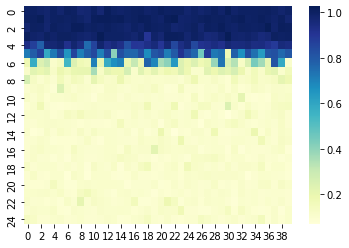

In [ ]:
net = model
wire_R = [(i+1)*2 for i in range(40)]
p_stuck = [0.01*(i) for i in range(40)]
R_std = [1e2*i for i in range(1, 101, 4)]


org_net_weight = net.fc1.W
org_net_bias = net.fc1.b

err_org = network_tester(net, test_loader, 800, 0, False).item()
print("original accuracy: ",err_org,"%")

result = []

for std in R_std:
    result_wire = []
    for var in p_stuck:
        device_params = {"Vdd": 1.8,
                 "r_wl": 20,
                 "r_bl": 20,
                 "m": 100,
                 "n": 100,
                 "r_on_mean": 1e4,
                 "r_on_stddev": std,
                 "r_off_mean": 1e5,
                 "r_off_stddev": std*10,
                 "dac_resolution": 5,
                 "adc_resolution": 8.3,
                 "device_resolution": 4,
                 "bias_scheme": 1/3,
                 "tile_rows": 4,
                 "tile_cols": 4,
                 "r_cmos_line": 600,
                 "r_cmos_transistor": 20,
                 "p_stuck_on": var,
                 "p_stuck_off": var}
        crb_new = crossbar(device_params)

        net.fc1.W = torch.nn.parameter.Parameter(org_net_weight)
        net.fc1.b = torch.nn.parameter.Parameter(org_net_bias)

        net.fc1.cb = crb_new
        net.fc1.remap()

        err = network_tester(net, test_loader, 800, 0, False).item()
        result_wire.append(err/err_org)

    result.append(result_wire)

print(result)
with open("result_non_ideal_CNN_ex_situ2.txt", 'w') as writefile:
    writefile.write(str(result))

ax = sns.heatmap(result, cmap="YlGnBu")
plt.show()

In [ ]:
import copy
org_weight = copy.deepcopy(net_base.fc1.W)
org_acc = test(net_base, device, test_loader)

results = []
with torch.no_grad():
    for i in range(net_base.fc1.W.shape[0]):
        res = []
        for j in range(net_base.fc1.W.shape[1]):
            net_base.fc1.W = copy.deepcopy(org_weight)
            net_base.fc1.W[i, j] = net_base.fc1.W[i, j] + 1

            acc_1 = test(net_base, device, test_loader, prints = False)

            net_base.fc1.W = copy.deepcopy(org_weight)
            net_base.fc1.W[i, j] = net_base.fc1.W[i, j] - 1

            acc_2 = test(model, device, test_loader, prints = False)
            res.append(((acc_1 + acc_2)/2)/org_acc)
        results.append(res)
        print(res)
    print(results)

ax = sns.heatmap(results, cmap="YlGnBu")
plt.show()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Average loss: 0.2260, Accuracy: 9305/10000 (93%)

[1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.007684040838259, 1.00768

KeyboardInterrupt: ignored